<a href="https://colab.research.google.com/github/SewarYousef/DataStructureAndAlgorithms/blob/master/DigitalSmileDesign_software.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MOUNTING, to get the data from our drive

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
shutil.copytree('/content/drive/My Drive/dataset', 'data')

Mounted at /content/drive


'data'

# PART I: Face Detection

### Importing Libraries

In [3]:
from typing import Any

from imutils import face_utils
import numpy as np
import imutils
import dlib
import cv2
import argparse
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib inline

from imutils.face_utils import rect_to_bb
from imutils.face_utils import shape_to_np
from imutils.face_utils import FACIAL_LANDMARKS_68_IDXS
from imutils.face_utils import FACIAL_LANDMARKS_5_IDXS
from imutils.face_utils import FACIAL_LANDMARKS_IDXS
from numpy import ndarray

from google.colab.patches import cv2_imshow

### Necessary funcions and methods

In [4]:
class FaceAligner:
    def __init__(self, predictor1, desiredLeftEye=(0.35, 0.35), desiredFaceWidth=256, desiredFaceHeight=None):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.predictor = predictor1
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight

        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, imG, gry, rectS):
        # convert the landmark (x, y)-coordinates to a NumPy array
        shapeS = self.predictor(gry, rectS)
        shapeS: ndarray[Any] = shape_to_np(shapeS)

        # simple hack ;)
        if len(shapeS) == 68:
            # extract the left and right eye (x, y)-coordinates
            (lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
            (rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
        else:
            (lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
            (rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]

        leftEyePts = shapeS[lStart:lEnd]
        rightEyePts = shapeS[rStart:rEnd]

        # compute the center of mass for each eye
        leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
        rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = (int((leftEyeCenter[0] + rightEyeCenter[0]) // 2),
                      int((leftEyeCenter[1] + rightEyeCenter[1]) // 2))

        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # apply the affine transformation
        (W, H) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(imG, M, (W, H),
                                flags=cv2.INTER_CUBIC)

        # return the aligned face
        return output


def empty(a):
    pass


# This code is to stack the 4 output images of the teeth right next to each other
def stackImages(scale, imgArray):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for X in range(0, rows):
            for Y in range(0, cols):
                if imgArray[X][Y].shape[:2] == imgArray[0][0].shape[:2]:
                    imgArray[X][Y] = cv2.resize(imgArray[X][Y], (0, 0), None, scale, scale)
                else:
                    imgArray[X][Y] = cv2.resize(imgArray[X][Y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]),
                                                None, scale, scale)
                if len(imgArray[X][Y].shape) == 2: imgArray[X][Y] = cv2.cvtColor(imgArray[X][Y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank] * rows
        # hor_con = [imageBlank] * rows
        for X in range(0, rows):
            hor[X] = np.hstack(imgArray[X])
        ver = np.vstack(hor)
    else:
        for X in range(0, rows):
            if imgArray[X].shape[:2] == imgArray[0].shape[:2]:
                imgArray[X] = cv2.resize(imgArray[X], (0, 0), None, scale, scale)
            else:
                imgArray[X] = cv2.resize(imgArray[X], (imgArray[0].shape[1], imgArray[0].shape[0]), None, scale, scale)
            if len(imgArray[X].shape) == 2: imgArray[X] = cv2.cvtColor(imgArray[X], cv2.COLOR_GRAY2BGR)
        hor = np.hstack(imgArray)
        ver = hor
    return ver

    # landmarks to specific face regions
FACIAL_LANDMARKS_IDXS = OrderedDict([
    ("mouth", (48, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 36)),
    ("jaw", (0, 17))
])

# Rectangular bounding box
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)


### Importing our image

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

# Load the image
damaged = cv2.imread('/content/data/damaged/_DSC0471.JPG')
images = cv2.imread('/content/data/fullface/in_6.jpg')
#img = cv2.resize(images, (600, 300))
# cv2_imshow(images)

### FACE DETECTOR

In [19]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/data/DLib/shape_predictor_68_face_landmarks.dat')

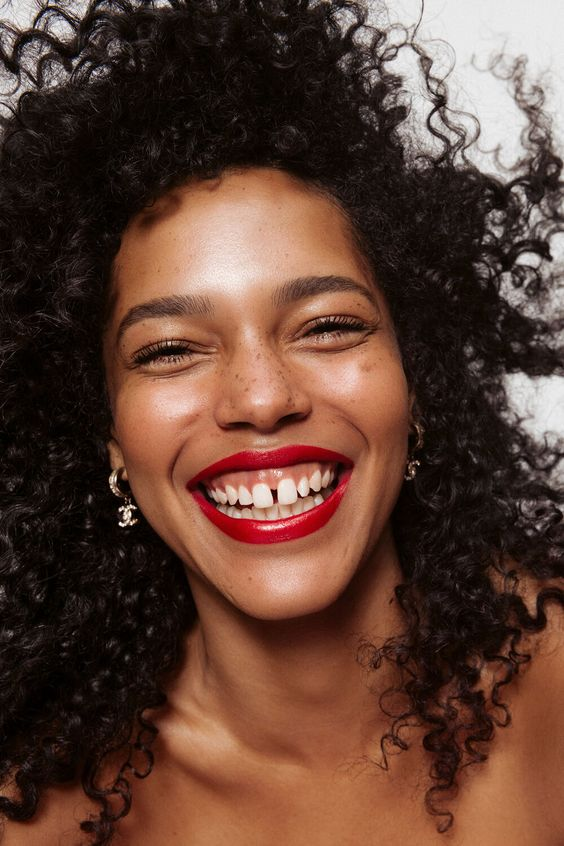

In [20]:
image = imutils.resize(images, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 1)
for (i, rect) in enumerate(rects):
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
cv2_imshow(images)

### FACE ALIGNER

In [21]:
al = FaceAligner(predictor, desiredFaceWidth=450)
for rect in rects:
    # extract the ROI of the *original* face, then align the face
    # using facial landmarks
    (x, y, w, h) = rect_to_bb(rect)
    faceOrig = imutils.resize(image[y:y + h, x:x + w], width=450)
    faceAligned = al.align(image, gray, rect)

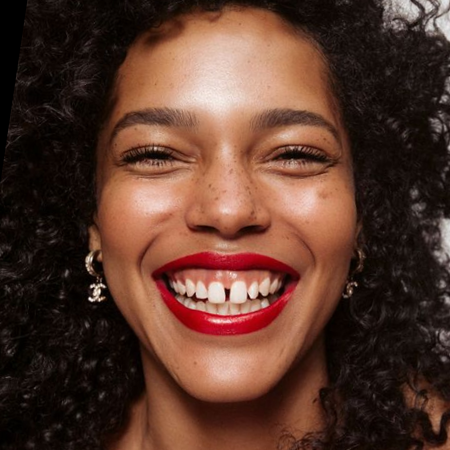

In [22]:
image = imutils.resize(faceAligned, width=450)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 1)
for (i, rect) in enumerate(rects):
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
cv2_imshow(image)

### FACE LANDMARKS

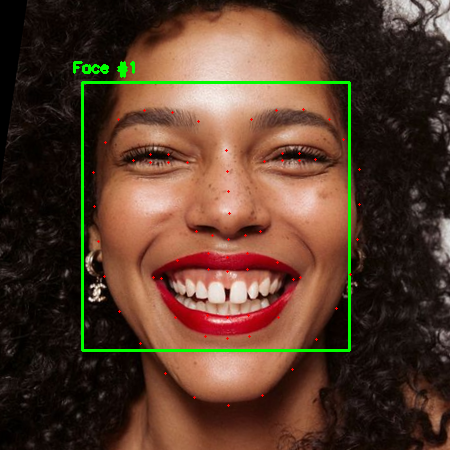

In [23]:
# FACE LANDMARKS
for (i, rect) in enumerate(rects):
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    for (x, y) in shape:
        cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
cv2_imshow(image)

### NOSE FEATURES

In [24]:
for (name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
    if name == "nose":
        # extract the ROI of the face region as a separate image
        (x1, y1, w1, h1) = cv2.boundingRect(np.array([shape[i:j]]))
        roi = image[y1:y1 + h1, x1:x1 + w1]
        roi = imutils.resize(roi, width=500, inter=cv2.INTER_CUBIC)

        print("esto ", shape[i:j])

esto  [[226 150]
 [227 171]
 [228 191]
 [229 213]
 [196 231]
 [212 235]
 [228 239]
 [245 235]
 [260 231]]


In [25]:
height, width = image[32].shape

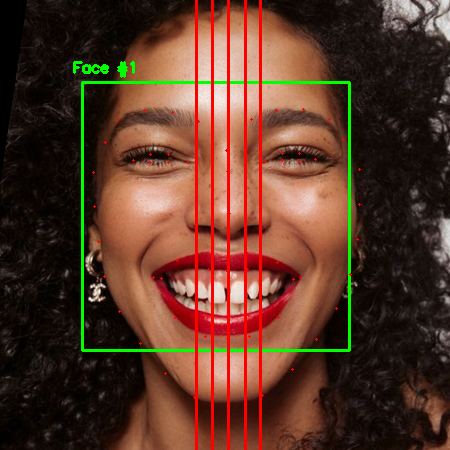

In [26]:
img = image.copy()

for (name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
  if name =="nose":
    for face in rects:
      # Predict the facial landmarks for each face
      landmarks = shape[i:j]

# Draw vertical line through point 32
point32 = landmarks[4]
pt1 = (int(point32[0]), 0)
pt2 = (int(point32[0]), height)
color = (0, 0, 255)
thickness = 2
cv2.line(img, pt1, pt2, color, thickness)


# Draw vertical line through point 36
point36 = landmarks[-1]
ptt1 = (int(point36[0]), 0)
ptt2 = (int(point36[0]), height)
cv2.line(img, ptt1, ptt2, color, thickness)

# Draw vertical line through point 33
point33 = landmarks[5]
pttt1 = (int(point33[0]), 0)
pttt2 = (int(point33[0]), height)
cv2.line(img, pttt1, pttt2, color, thickness)

# Draw vertical line through point 34
point34 = landmarks[6]
ptttt1 = (int(point34[0]), 0)
ptttt2 = (int(point34[0]), height)
cv2.line(img, ptttt1, ptttt2, color, thickness)

# Draw vertical line through point 35
point35 = landmarks[7]
pttt15 = (int(point35[0]), 0)
pttt25 = (int(point35[0]), height)
cv2.line(img, pttt15, pttt25, color, thickness)

cv2_imshow(img)

### MOUTH EXTRACTION

In [27]:
cv2.__version__

'4.8.0'

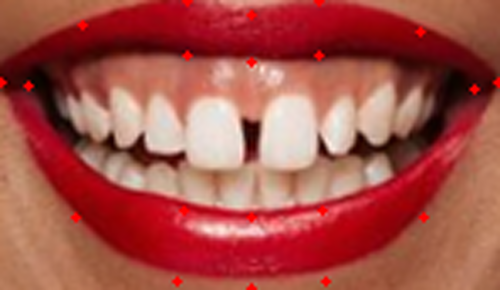

In [28]:
# MOUTH EXTRACTION
for (name, (i, j)) in FACIAL_LANDMARKS_IDXS.items():
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    clone = image.copy()
    #cv2.putText(clone, name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    if name == "mouth":
        for (x, y) in shape[i:j]:
            (x1, y1, w1, h1) = cv2.boundingRect(np.array([shape[i:j]]))
            roi = clone[y1:y1 + h1, x1:x1 + w1]
            roi = imutils.resize(roi, width=500, inter=cv2.INTER_CUBIC)
        # show the particular face part
cv2_imshow(roi)

In [29]:
roi.shape

(290, 500, 3)

###TOOTH SEGMENTATION (SAM)

HSV color space image and splitting it into three channels

In [30]:
# Load the image
# damagedSmile = cv2.imread('/content/data/damaged/_DSC0471.JPG')
perfectSmile = cv2.imread('/content/data/perfect/Screen Shot 2022-05-30 at 9.55.00 AM.png')

In [31]:
h, w, c = roi.shape

In [32]:
dim = (w, h)

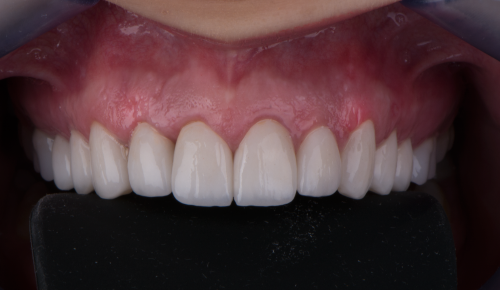

In [33]:
res = cv2.resize(perfectSmile, dim, interpolation=cv2.INTER_LINEAR)
cv2_imshow(res)

In [34]:
# Convert to HSV color space
hsv = cv2.cvtColor(res, cv2.COLOR_BGR2HSV)

# Split the HSV image into its three channels
h, s, v = cv2.split(hsv)

# Create a mask for the red color
mask = cv2.inRange(h, 0, 255) + cv2.inRange(h, 10, 20)

Darkening our image

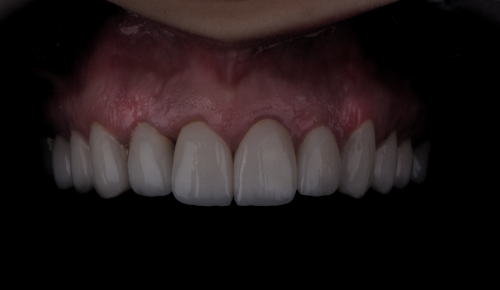

In [35]:
# Darken the Value channel where the mask is non-zero
darkened_v = cv2.subtract(v, 70, mask=mask)

# Merge the channels back into a single image
darkened = cv2.merge((h, s, darkened_v))

# Convert back to the BGR color space
darkened = cv2.cvtColor(darkened, cv2.COLOR_HSV2BGR)
cv2_imshow(darkened)

In [36]:
darkened.shape

(290, 500, 3)

Here the RoboFlow SAM model section starts

In [37]:
!nvidia-smi

Wed Dec 20 04:24:25 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              30W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [38]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


Install Segment Anything Model (SAM) and other dependencies

In [39]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-bzr172s6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-bzr172s6
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=25d7c9d537244dd8f4baf2216e57e9485d3f2b99577da35c8595b287f9971eee
  Stored in directory: /tmp/pip-ephem-wheel-cache-jj6tywkh/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [40]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This b

In [41]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [42]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


Loading SAM Model

In [43]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [44]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

### Automated Mask Generation

In [45]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.99,
    stability_score_thresh=0.98,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

Generate masks with SAM

In [46]:
import supervision as sv

sam_result = mask_generator_2.generate(darkened)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [52]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

In [53]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=darkened.copy(), detections=detections)

sv.plot_images_grid(
    images=[darkened, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

ValueError: ignored

Interaction with segmentation results

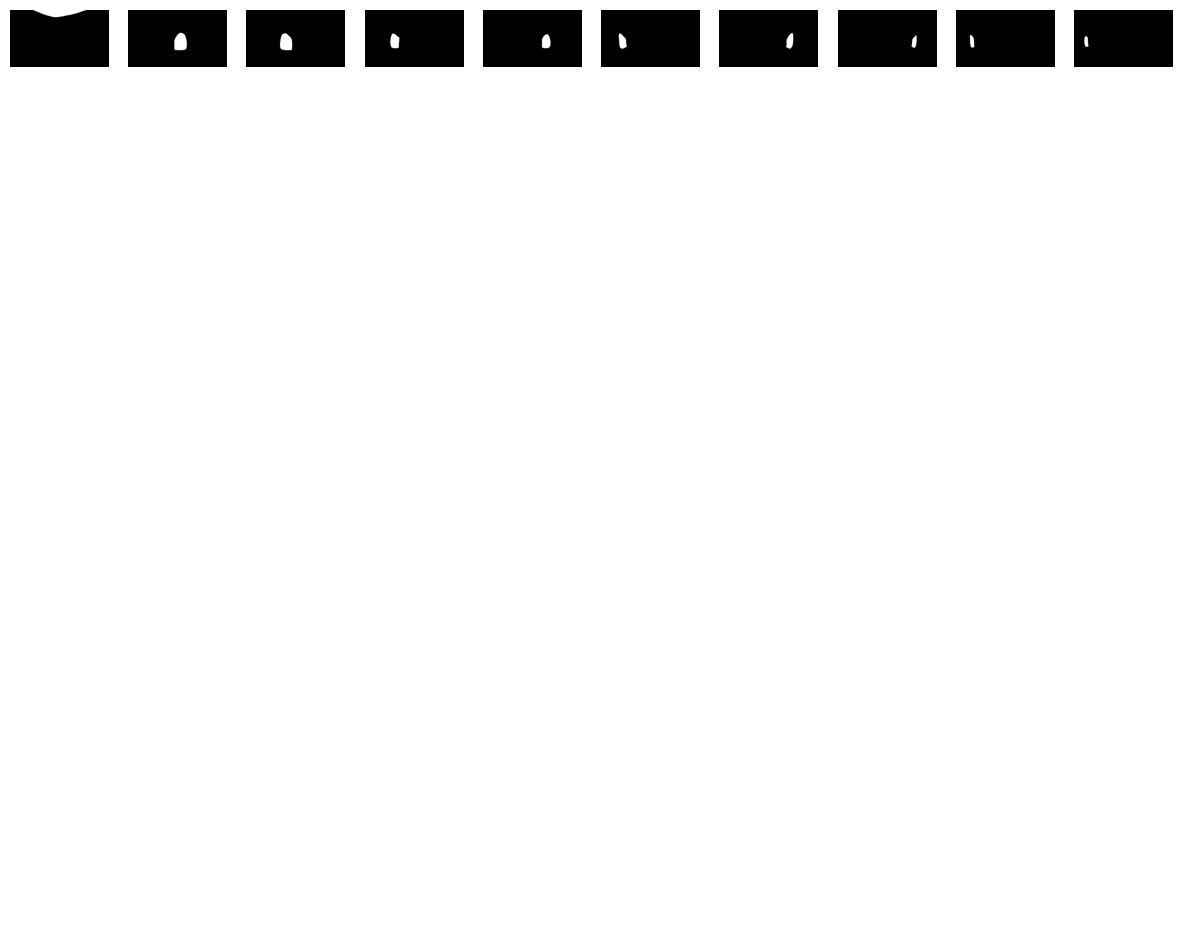

<Figure size 640x480 with 0 Axes>

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

masks = [
    mask['segmentation']
    for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

# sns.set_style("blue")
sv.plot_images_grid(
    images=masks,
    grid_size=(2, int(len(masks) / 1)),
    size=(15, 15)
)

plt.savefig(r'C:\Users\after_images\output segments\output.png')

## Splitting and sorting our detected objects
This step was done by binarizing our code to get our objects contoured and calculating each object's area

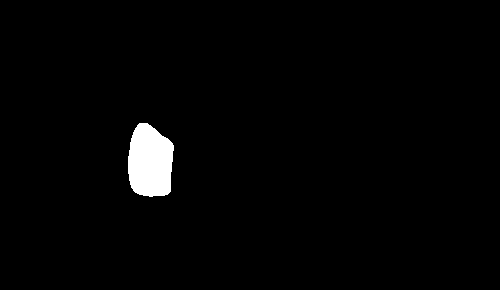

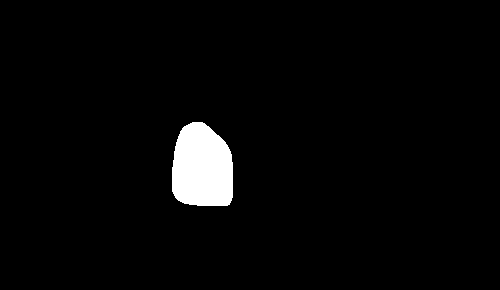

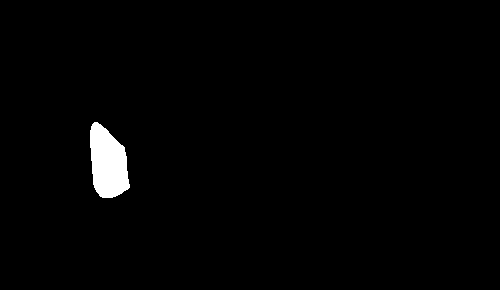

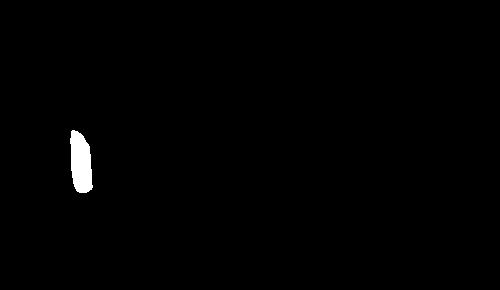

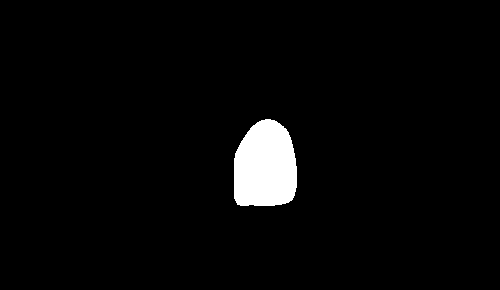

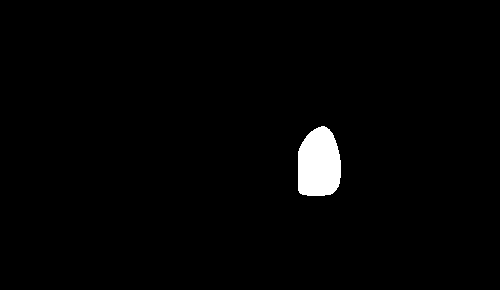

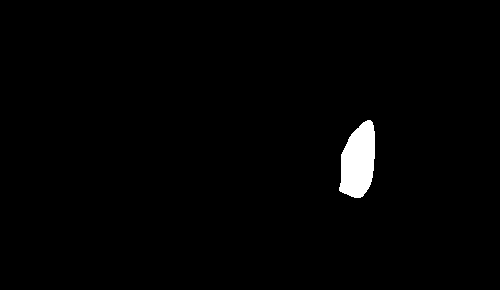

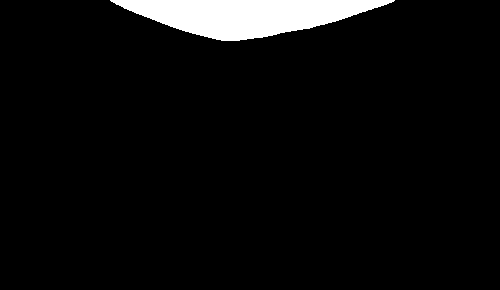

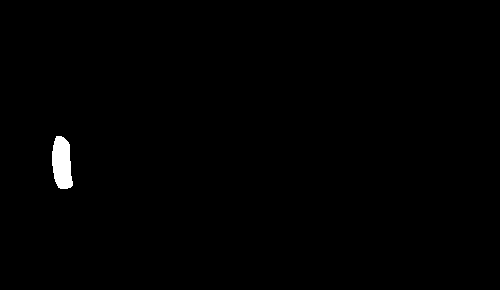

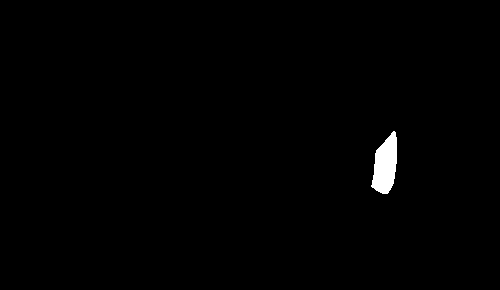

In [55]:
areas = []
for i in range(len(sam_result)):
    # masks[i]['segmentation']
    arr = sam_result[i]['segmentation']
    binary = np.zeros(darkened.shape[:2], dtype=np.uint8)
    binary[arr == True] = 255
    cv2_imshow(binary)
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for cnt in contours:
      area = cv2.contourArea(cnt)
      # area = sorted(cnt, key=cv2.contourArea, reverse=True)
      areas.append(area)
      # print(f"Contour areas for mask {i+1}: {areas}")

areas.pop()
areas = sorted(areas)

Visualizing the areas in a histogram

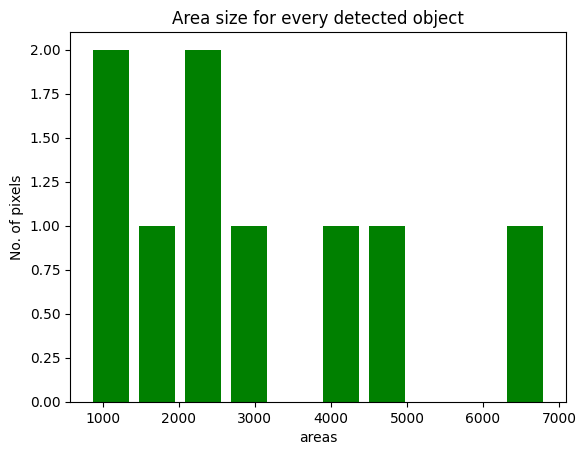

In [56]:
import matplotlib.pyplot as plt

# plotting a histogram
plt.hist(areas, bins = 10, color = 'green', histtype = 'bar', rwidth = 0.8)

# x-axis label
plt.xlabel('areas')
# frequency label
plt.ylabel('No. of pixels')
# plot title
plt.title('Area size for every detected object')

# function to show the plot
plt.show()

Calculating the avarage of the areas

In [57]:
avg = sum(areas) / len(areas)
avg

2956.722222222222

## Updating the detected teeth
We updated the detected teeth by limitating the detected areas using the average size of the detected objects

In [58]:
for i in range(len(sam_result)):
  if sam_result[i]['area'] > (avg*2):
    del sam_result[i]
    # if sam_result[i]['area'] < (avg/2):
    # del sam_result[i]
  # if sam_result[i]['area'] < (avg/2):
  #   del sam_result[i]

IndexError: ignored

In [59]:
# This is the number of the detected objects after limitating the size of the objects
len(sam_result)

9

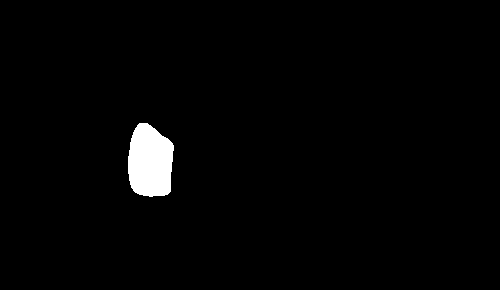

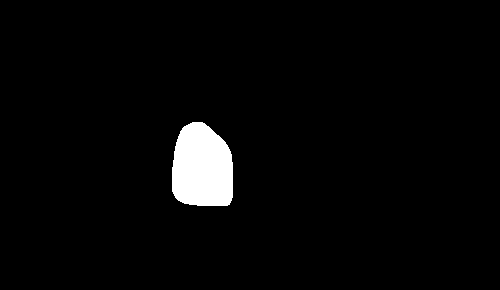

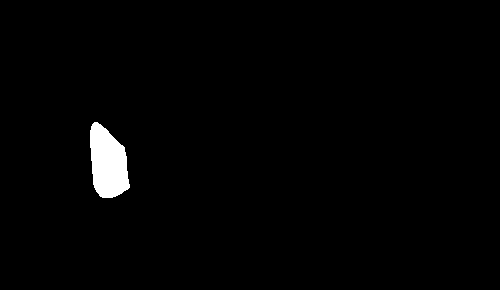

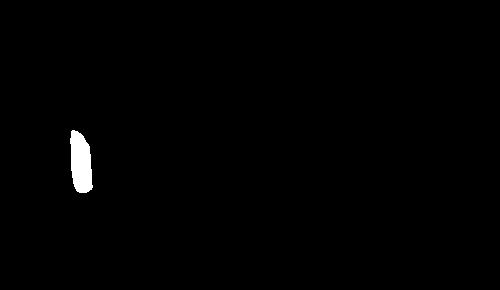

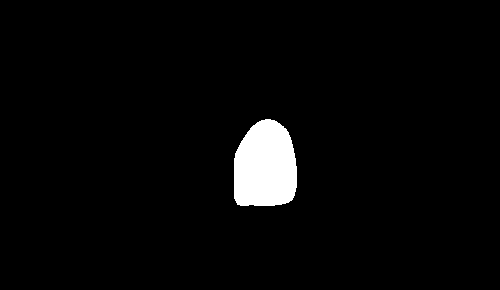

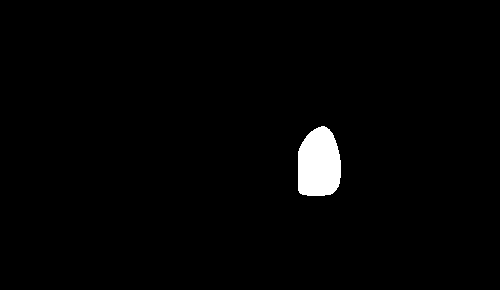

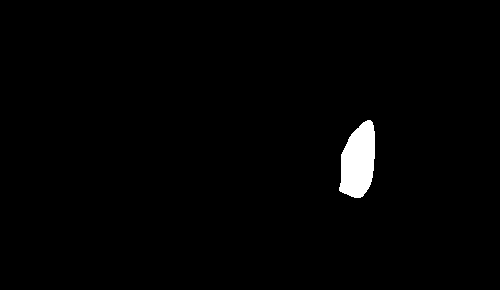

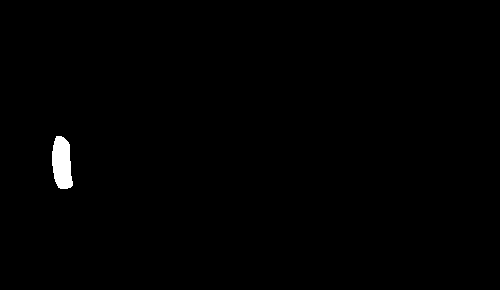

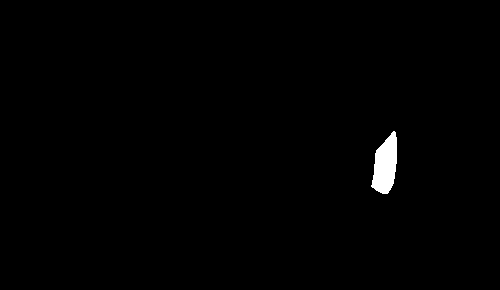

1045.0

In [60]:
updated_areas = []
testS = []
img_count = 1
for i in range(len(sam_result)):
    arr = sam_result[i]['segmentation']
    binary = np.zeros(darkened.shape[:2], dtype=np.uint8)
    binary[arr == True] = 255
    testS.append(binary)
    cv2_imshow(binary)

    # cv2.imwrite(binary)
    print('\n')
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for cnt in contours:
      area1 = cv2.contourArea(cnt)
      # area = sorted(cnt, key=cv2.contourArea, reverse=True)
      updated_areas.append(area1)
      # print(f"Contour areas for mask {i+1}: {areas}")

updated_areas.pop()

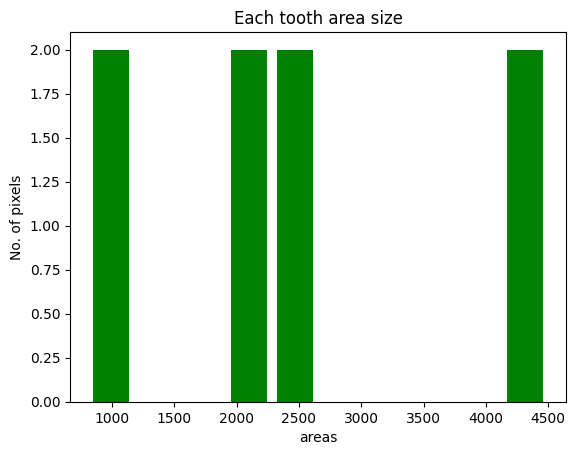

In [61]:
import matplotlib.pyplot as plt

# plotting a histogram
plt.hist(updated_areas, bins = 10, color = 'green', histtype = 'bar', rwidth = 0.8)

# x-axis label
plt.xlabel('areas')
# frequency label
plt.ylabel('No. of pixels')
# plot title
plt.title('Each tooth area size')

# function to show the plot
plt.show()

In [62]:
detections = sv.Detections.from_sam(sam_result)

annotated_image = mask_annotator.annotate(scene=darkened.copy(), detections=detections)

sv.plot_images_grid(
    images=[darkened, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

ValueError: ignored

### new

In [63]:
for item in range(len(sam_result)):
  print(sam_result[item]['area'])

2746
4334
2205
1099
4619
2524
2086
868
1113


In [64]:
sa = []
if(len(sam_result)/2 != 1):
  for item in range(len(sam_result)):
    sa.append(sam_result[item]['area'])

  min_value = min(sa)
  min_index = sa.index(min_value)
  print(min_index)

7


In [65]:
new_array= sam_result.copy()

In [ ]:
new_array.pop(min_index)

In [67]:
len(new_array)

8

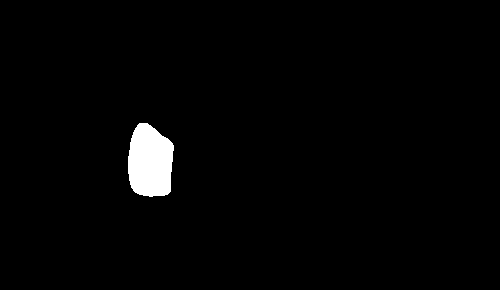

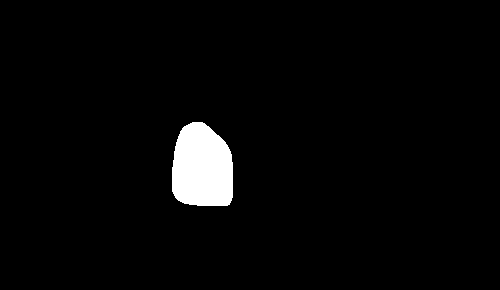

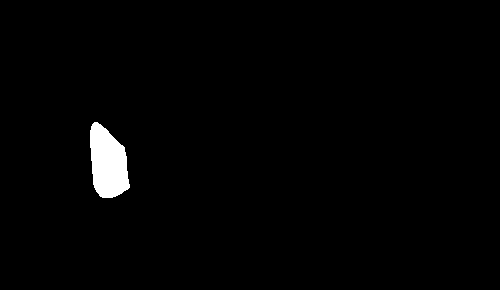

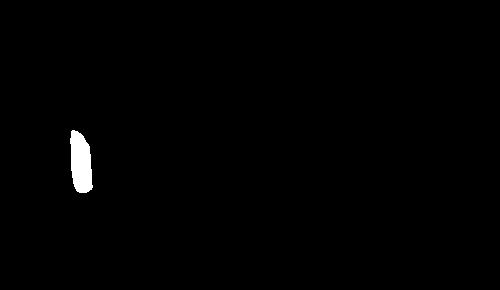

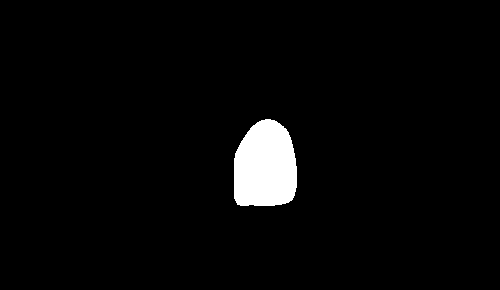

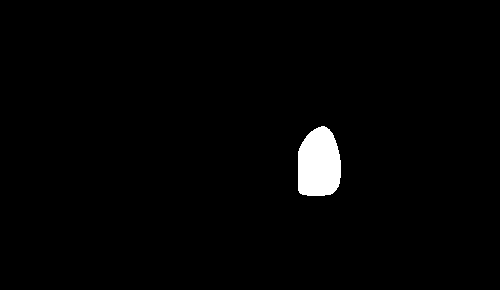

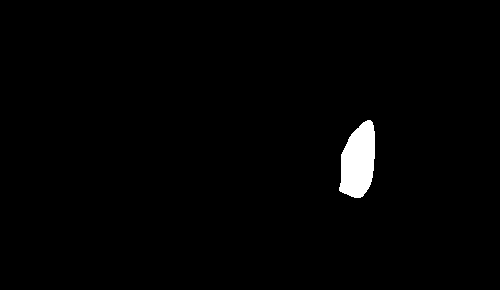

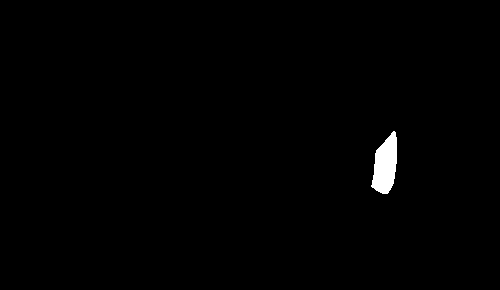

807.0

In [68]:
updated_areasX = []
testafterremoving = []
for i in range(len(new_array)):
    arrX = new_array[i]['segmentation']
    binaryX = np.zeros(darkened.shape[:2], dtype=np.uint8)
    binaryX[arrX == True] = 255
    testafterremoving.append(binaryX)
    cv2_imshow(binaryX)
    print('\n')
    contoursX, hierarchyX = cv2.findContours(binaryX, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contoursX = sorted(contoursX, key=cv2.contourArea, reverse=True)
    for cnt in contoursX:
      areaX = cv2.contourArea(cnt)
      updated_areasX.append(areaX)

updated_areas.pop()

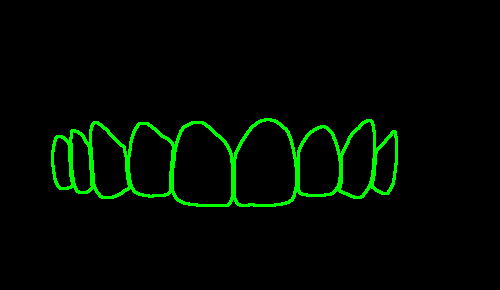

In [69]:
original_image = roi.copy()

# Create a blank image to draw contours on
contour_img = np.zeros_like(original_image)

for i in range(len(testS)):
    (tooth, hierarchy) = cv2.findContours(testS[i].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in tooth:
        cv2.drawContours(contour_img, [c], -1, (0, 255, 0), 2)

# Apply the contours on the original image
result = cv2.addWeighted(original_image, 1, contour_img, 1, 0)

# Display the result
# cv2_imshow(result) # to show the mask on the damaged image before shifting and resizing the mask
cv2_imshow(contour_img) # to show the mask only

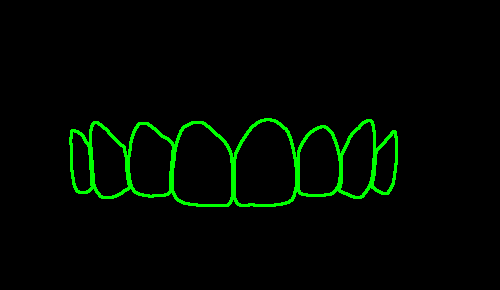

In [70]:
original_imageX = roi.copy()

# Create a blank image to draw contours on
contour_imgX = np.zeros_like(original_imageX)

for i in range(len(testafterremoving)):
    (toothX, hierarchyxX) = cv2.findContours(testafterremoving[i].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in toothX:
        cv2.drawContours(contour_imgX, [c], -1, (0, 255, 0), 2)

# Apply the contours on the original image
resultX = cv2.addWeighted(original_imageX, 1, contour_imgX, 1, 0)

# Display the result
# cv2_imshow(resultX) # to show the mask on the damaged image before shifting and resizing the mask
cv2_imshow(contour_imgX) # to show the mask only


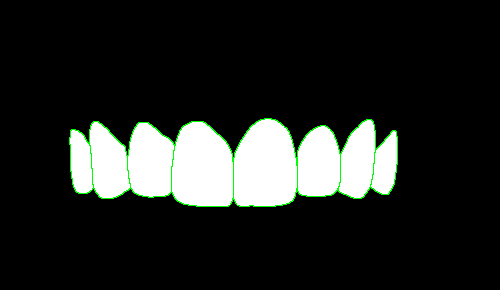

In [71]:
import numpy as np
import cv2

original_imagey= roi.copy()

# Create a blank image to draw contours on
contour_imgy = np.zeros_like(original_imagey)

for i in range(len(testafterremoving)):
    (toothX, hierarchyxX) = cv2.findContours(testafterremoving[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in toothX:
        cv2.drawContours(contour_imgy, [c], -1, (0, 255, 0), 2)
        cv2.fillPoly(contour_imgy, pts=[c], color=(255, 255, 255))  # Fill the contour with color

# Display the result
cv2_imshow(contour_imgy)

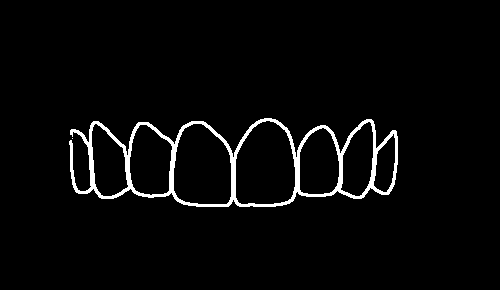

In [72]:
imgH1= contour_imgX.copy()
imgH1 = cv2.cvtColor(imgH1, cv2.COLOR_BGR2GRAY)
heightH, widthH = imgH1.shape
# Threshold the grayscale image
_, imgH1 = cv2.threshold(imgH1, 127, 255, cv2.THRESH_BINARY)

k = []
vertical_start_point1 = None
for col in range(widthH):
    for row in range(heightH):
        if (imgH1[row][col] == 255):
          r = [row, col]
          k.append(r)
          break

# Our first vertical pixel is ptV1
Xh, Yh= int(k[0][0]), int(k[0][1])
vertical_start_point1 = (Yh, Xh)
# Draw a circle at the vertical_start_point on the image
radius = 3
cv2.circle(imgH1, vertical_start_point1, radius, (0, 255, 0), -1)

# Show the roi image with the marked middle point
cv2_imshow(imgH1)

In [73]:
vertical_start_point1

(69, 137)

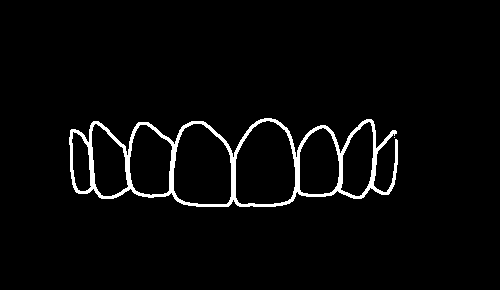

In [74]:
imgH2= contour_imgX.copy()
imgH2 = cv2.cvtColor(imgH2, cv2.COLOR_BGR2GRAY)
# Threshold the grayscale image
_, imgH2 = cv2.threshold(imgH2, 127, 255, cv2.THRESH_BINARY)

k = []
vertical_start_point2 = None
for col in range(widthH-1, -1, -1):
    for row in range(heightH):
        if (imgH2[row][col] == 255):
          r = [row, col]
          k.append(r)
          break

# Our first vertical pixel is ptV1
Xh, Yh= int(k[0][0]), int(k[0][1])
vertical_start_point2 = (Yh, Xh)
# Draw a circle at the vertical_start_point on the image
radius = 3
cv2.circle(imgH2, vertical_start_point2, radius, (0, 255, 0), -1)

# Show the roi image with the marked middle point
cv2_imshow(imgH2)

In [75]:
vertical_start_point2

(397, 136)

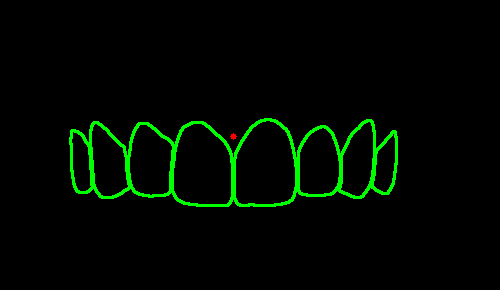

In [76]:
center_vertical_point= contour_imgX.copy()
# Draw a circle at the vertical_start_point2_start_point on the image
radius = 3
center_mask_point= ((vertical_start_point1[0]+vertical_start_point2[0])//2, (vertical_start_point1[1]+vertical_start_point2[1])//2)

cv2.circle(center_vertical_point, center_mask_point, radius, (0, 0, 255), -1)

# Show the roi image with the marked middle point
cv2_imshow(center_vertical_point)

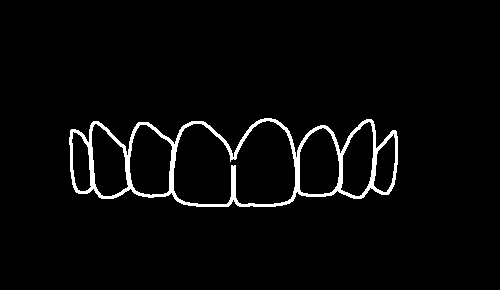

In [77]:
# Assuming you have already defined the 'contour_imgX' and 'horizontal_start_point1' and 'horizontal_start_point2'

# contour_imgm = imgH1.copy()
Rudys = contour_imgX.copy()
Rudys = cv2.cvtColor(Rudys, cv2.COLOR_BGR2GRAY)

_, Rudys = cv2.threshold(Rudys, 127, 255, cv2.THRESH_BINARY)

# Calculate the center of the contour
contour_moment = cv2.moments(Rudys)
contour_center_x = int(contour_moment["m10"] / contour_moment["m00"])
contour_center_y = int(contour_moment["m01"] / contour_moment["m00"])
contour_center_point = (contour_center_x, contour_center_y)

# Draw a circle at the contour center on the image
radius = 3
img0 = cv2.circle(Rudys, contour_center_point, radius, (0, 0, 255), -1)

cv2_imshow(Rudys)

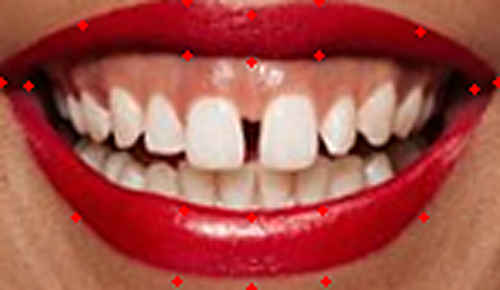

In [78]:
sam_roi = roi.copy()
# Split the image into channels
b, g, r = cv2.split(sam_roi)

# Apply Gaussian blur to each channel
blurred_b = cv2.GaussianBlur(b, (0, 0), 3)
blurred_g = cv2.GaussianBlur(g, (0, 0), 3)
blurred_r = cv2.GaussianBlur(r, (0, 0), 3)

# Calculate the sharpened channels by subtracting the blurred channels from the original channels
sharpened_b = cv2.addWeighted(b, 1.5, blurred_b, -0.5, 0)
sharpened_g = cv2.addWeighted(g, 1.5, blurred_g, -0.5, 0)
sharpened_r = cv2.addWeighted(r, 1.5, blurred_r, -0.5, 0)

# Merge the sharpened channels back into a BGR image
sharpened_image = cv2.merge((sharpened_b, sharpened_g, sharpened_r))
cv2_imshow(sharpened_image)

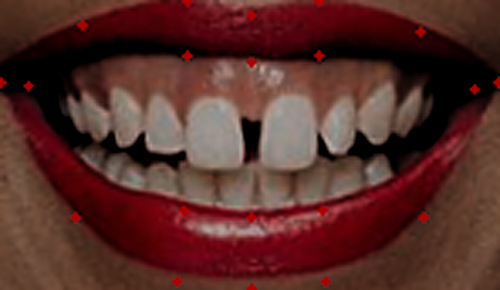

In [79]:
# Convert to HSV color space
hsv_damaged = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2HSV)

# Split the HSV image into its three channels
hD, sD, vD = cv2.split(hsv_damaged)

# Create a mask for the red color
damaged_mask = cv2.inRange(hD, 0, 255) + cv2.inRange(hD, 10, 20)

# Darken the Value channel where the mask is non-zero
darkened_damage = cv2.subtract(vD, 80, mask=damaged_mask)

# Merge the channels back into a single image
dark_damage = cv2.merge((hD, sD, darkened_damage))

# Convert back to the BGR color space
dark_damage = cv2.cvtColor(dark_damage, cv2.COLOR_HSV2BGR)
cv2_imshow(dark_damage)

In [80]:
damage_sam_result = mask_generator_2.generate(dark_damage)

In [81]:
mask_annotator = sv.MaskAnnotator()

detectionsD = sv.Detections.from_sam(sam_result=damage_sam_result)

annotated_imageD = mask_annotator.annotate(scene=dark_damage.copy(), detections=detectionsD)

sv.plot_images_grid(
    images=[dark_damage, annotated_imageD],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

ValueError: ignored

In [82]:
areasD = []
for i in range(len(damage_sam_result)):
    arrD = damage_sam_result[i]['segmentation']
    binaryD = np.zeros(dark_damage.shape[:2], dtype=np.uint8)
    binaryD[arrD == True] = 255
    contoursD, hierarchyD = cv2.findContours(binaryD, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contoursD = sorted(contoursD, key=cv2.contourArea, reverse=True)
    for cnt in contoursD:
      areaD = cv2.contourArea(cnt)
      areasD.append(areaD)

areasD.pop()

102618.5

In [83]:
len(damage_sam_result)

2

In [84]:
ar = []
for i in range(len(damage_sam_result)):
  ar.append(damage_sam_result[i]['area'])

In [85]:
ar


[3724, 103190]

In [86]:
damaged_avg = sum(ar) / len(ar)
damaged_avg

53457.0

In [87]:
for i in range(len(damage_sam_result)):
  x = damage_sam_result[i]['area']
  if x > (damaged_avg*2):
    del damage_sam_result[i]

In [88]:
len(damage_sam_result)

2

In [89]:
updated_damaged_areas = []
final_damaged_masks = []
for i in range(len(damage_sam_result)):
    arrD = damage_sam_result[i]['segmentation']
    binaryD = np.zeros(dark_damage.shape[:2], dtype=np.uint8)
    binaryD[arrD == True] = 255
    final_damaged_masks.append(binaryD)
    contoursD, hierarchyD = cv2.findContours(binaryD, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contoursD = sorted(contoursD, key=cv2.contourArea, reverse=True)
    for cnt in contoursD:
      area1D = cv2.contourArea(cnt)
      updated_damaged_areas.append(area1D)

updated_damaged_areas.pop()

102618.5

In [90]:
detections = sv.Detections.from_sam(damage_sam_result)

annotated_imageD = mask_annotator.annotate(scene=dark_damage.copy(), detections=detections)

sv.plot_images_grid(
    images=[dark_damage, annotated_imageD],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

ValueError: ignored

In [91]:
da = []
if(len(damage_sam_result)/2 != 1):
  for item in range(len(damage_sam_result)):
    da.append(damage_sam_result[item]['area'])

  mini_value = min(da)
  mini_index = da.index(mini_value)
  # print(mini_index)
  damage_sam_result.pop(mini_index)

In [92]:
final_damaged_masks = []
for i in range(len(damage_sam_result)):
  arrDX = damage_sam_result[i]['segmentation']
  binaryDX = np.zeros(dark_damage.shape[:2], dtype=np.uint8)
  binaryDX[arrDX == True] = 255
  final_damaged_masks.append(binaryDX)

In [93]:
len(final_damaged_masks)

2

In [94]:
detections = sv.Detections.from_sam(damage_sam_result)

annotated_imageD = mask_annotator.annotate(scene=dark_damage.copy(), detections=detections)

sv.plot_images_grid(
    images=[dark_damage, annotated_imageD],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

ValueError: ignored

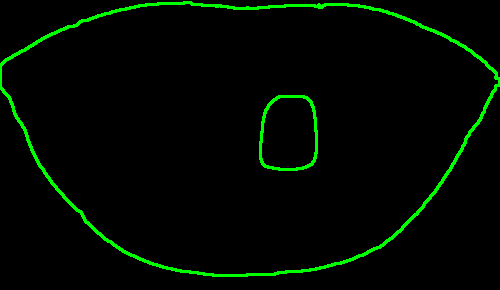

In [95]:
# Load the original image
orig_imageX = roi.copy()

# Create a blank image to draw contours on
cont_imgX = np.zeros_like(orig_imageX)

for i in range(len(final_damaged_masks)):
    (toX, hierX) = cv2.findContours(final_damaged_masks[i].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in toX:
        cv2.drawContours(cont_imgX, [c], -1, (0, 255, 0), 2)

# Display the result
cv2_imshow(cont_imgX)

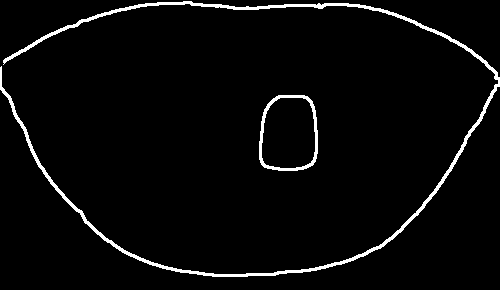

In [96]:
# First vertical point starting from the left
imgageeH1= cont_imgX.copy()
imgageeH1 = cv2.cvtColor(imgageeH1, cv2.COLOR_BGR2GRAY)
heH, wiH = imgageeH1.shape
# Threshold the grayscale image
_, imgageeH1 = cv2.threshold(imgageeH1, 127, 255, cv2.THRESH_BINARY)

k = []
start_point1 = None
for col in range(wiH):
    for row in range(heH):
        if (imgageeH1[row][col] == 255):
          r = [row, col]
          k.append(r)
          break

# Our first vertical pixel is ptV1
Xh, Yh= int(k[0][0]), int(k[0][1])
start_point1 = (Yh, Xh)
# Draw a circle at the vertical_start_point on the image
radius = 3
cv2.circle(imgageeH1, start_point1, radius, (0, 255, 0), -1)

# Show the roi image with the marked middle point
cv2_imshow(imgageeH1)

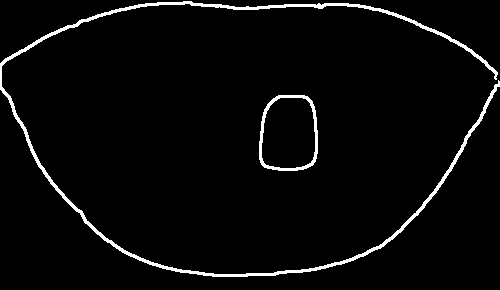

In [97]:
# First vertical point starting from the right
imgageeH2= cont_imgX.copy()
imgageeH2 = cv2.cvtColor(imgageeH2, cv2.COLOR_BGR2GRAY)
# Threshold the grayscale image
_, imgageeH2 = cv2.threshold(imgageeH2, 127, 255, cv2.THRESH_BINARY)

k = []
start_point2 = None
for col in range(wiH-1, -1, -1):
    for row in range(heH):
        if (imgageeH2[row][col] == 255):
          r = [row, col]
          k.append(r)
          break

# Our first vertical pixel is ptV1
Xh, Yh= int(k[0][0]), int(k[0][1])
start_point2 = (Yh, Xh)
# Draw a circle at the vertical_start_point on the image
radius = 3
cv2.circle(imgageeH2, start_point2, radius, (0, 255, 0), -1)

# Show the roi image with the marked middle point
cv2_imshow(imgageeH2)

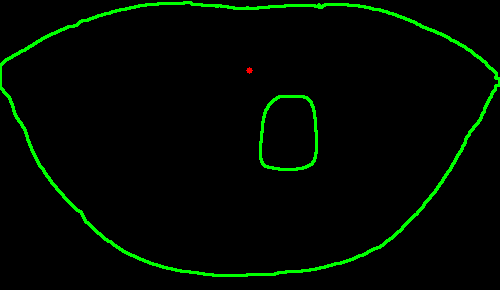

In [98]:
center_point= cont_imgX.copy()
# Draw a circle at the horizontal_start_point on the image
radius = 3
center_m_point= ((start_point1[0]+start_point2[0])//2, (start_point1[1]+start_point2[1])//2)

cv2.circle(center_point, center_m_point, radius, (0, 0, 255), -1)

# Show the roi image with the marked middle point
cv2_imshow(center_point)

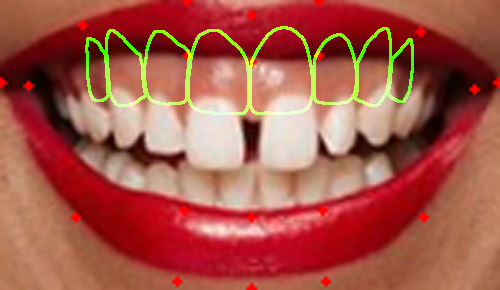

In [99]:
copyx = roi.copy()
contour_copyx = contour_imgX.copy()
rows, cols, _ = copyx.shape

# shift points up down (y)
xc , yc = center_m_point # Center point of the damaged smile (vertical rare left & right pixels)
xh , yh = contour_center_point # Center point of the perfect smile (moment method)
y = yc - yh
x = xc - xh

# shift difference value
R = np.float32([[1, 0, x], [0, 1, y]])
# contour after being shifted
shifted_contour_imgD = cv2.warpAffine(contour_copyx, R, (cols, rows))
# applying the shifted contour on our image
aftermask = cv2.addWeighted(copyx, 1, shifted_contour_imgD , 1, 0)

cv2_imshow(aftermask)

### Fitting the contours of the perfect smile on the damaged smile

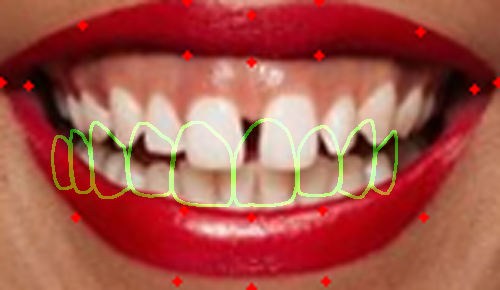

In [100]:
# Load the original image
original_image = roi.copy()

# Create a blank image to draw contours on
contour_img = np.zeros_like(original_image)

for i in range(len(testS)):
    (tooth, hierarchy) = cv2.findContours(testS[i].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in tooth:
        cv2.drawContours(contour_img, [c], -1, (0, 255, 0), 2)

# Apply the contours on the original image
result = cv2.addWeighted(original_image, 1, contour_img, 0.5, 0)

# Display the result
cv2_imshow(result)